## Pandas Netflix HW

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

Сначала прочитаем данные

In [2]:
url='https://drive.google.com/file/d/1QaM045XW3O10UOqHInnIpJJLWJMfyhW-/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url)
df.columns = ['country_code', 'country', 'total_library_size', 'n_tv_shows', 'n_movies', 'basic_fee_mnth', 'std_fee_mnth', 'premium_fee_mnth']
df.head()

,country_code,country,total_library_size,n_tv_shows,n_movies,basic_fee_mnth,std_fee_mnth,premium_fee_mnth
0,ar,Argentina,4760,3154,1606,3.74,6.30,9.26
1,au,Australia,6114,4050,2064,7.84,12.12,16.39
2,at,Austria,5640,3779,1861,9.03,14.67,20.32
3,be,Belgium,4990,3374,1616,10.16,15.24,20.32
4,bo,Bolivia,4991,3155,1836,7.99,10.99,13.99


Подтянем данные по зарплатам. Часть возьмем из википедии, другую часть с менее достоверного сайта

In [3]:
sheet_id = '1pYIiDFisiVwEvQA8fJEIkTjdXR1J4_-z73aLE7E-Jkg'
sheet_name = 'wikipedia_wages'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
df_wages = pd.read_csv(url)
wages_ppp = df_wages[['Country', '2019']]
wages_ppp.head()

,Country,2019
0,Luxembourg *,"68,681"
1,Iceland *,"68,006"
2,Switzerland *,"66,567"
3,United States *,"65,836"
4,Denmark *,"57,150"


In [4]:
#преобразим данные
wages_ppp['Country'] = wages_ppp['Country'].apply(lambda x: ''.join(x.split('*')).strip())
wages_ppp['annual_wage'] = wages_ppp['2019'].apply(lambda x: int(''.join(x.split(','))) )

#добавим помесячную зарплату
wages_ppp['mnth_wage'] = round(wages_ppp['annual_wage']/12, 2)

#преобразуем названия колонок
wages_ppp = wages_ppp[['Country', 'annual_wage', 'mnth_wage']]
wages_ppp = wages_ppp.rename(columns={"Country":"country"})

#поправим названия стран
wages_ppp['country'] = wages_ppp['country'].replace({'Czech Republic':'Czechia'})

wages_ppp.head()

,country,annual_wage,mnth_wage
0,Luxembourg,68681,5723.42
1,Iceland,68006,5667.17
2,Switzerland,66567,5547.25
3,United States,65836,5486.33
4,Denmark,57150,4762.50


Приджойним получившийся датасет к исходным данным, разделим данные на две части - с подтянувшейся и не подтянувшейся зарплатой

In [5]:
full_df = df.merge(wages_ppp, how='left', on='country')
part_1 = full_df[~full_df['annual_wage'].isnull()]
part_2 = full_df[full_df['annual_wage'].isnull()]

Подтянем недостающие зарплаты

In [6]:
sheet_id = '1pYIiDFisiVwEvQA8fJEIkTjdXR1J4_-z73aLE7E-Jkg'
sheet_name = 'wages_part2'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
wages_2 = pd.read_csv(url)

wages_2.head()

,Rank,Country,Avg income per year,Avg income per month
0,1,Monaco,"186,080 $","15,507 $"
1,2,Bermuda,"112,240 $","9,353 $"
2,3,Switzerland,"82,620 $","6,885 $"
3,4,Luxembourg,"80,860 $","6,738 $"
4,5,Norway,"78,290 $","6,524 $"


In [7]:
#переименуем колонки
wages_2 = wages_2.rename(columns={'Country':'country', 'Avg income per year':'annual_wage', 'Avg income per month':'mnth_wage'})

#преобразуем данные
wages_2['annual_wage'] = wages_2['annual_wage'].apply(lambda x:int(''.join(''.join(x.split(',')).split('$')).strip()))
wages_2['mnth_wage'] = wages_2['mnth_wage'].apply(lambda x:int(''.join(''.join(x.split(',')).split('$')).strip()))

wages_2.head()

,Rank,country,annual_wage,mnth_wage
0,1,Monaco,186080,15507
1,2,Bermuda,112240,9353
2,3,Switzerland,82620,6885
3,4,Luxembourg,80860,6738
4,5,Norway,78290,6524


In [8]:
part_2 = part_2.merge(wages_2, how='left', on='country')[['country_code', 'country', 'total_library_size', 'n_tv_shows', 'n_movies', 'basic_fee_mnth', 'std_fee_mnth', 'premium_fee_mnth', 'annual_wage_y', 'mnth_wage_y']]

In [9]:
part_2.head()

,country_code,country,total_library_size,n_tv_shows,n_movies,basic_fee_mnth,std_fee_mnth,premium_fee_mnth,annual_wage_y,mnth_wage_y
0,ar,Argentina,4760,3154,1606,3.74,6.30,9.26,NaN,NaN
1,bo,Bolivia,4991,3155,1836,7.99,10.99,13.99,3180.0,265.0
2,br,Brazil,4972,3162,1810,4.61,7.11,9.96,7850.0,654.0
3,bg,Bulgaria,6797,4819,1978,9.03,11.29,13.54,9630.0,803.0
4,co,Colombia,4991,3156,1835,4.31,6.86,9.93,5790.0,483.0


In [10]:
part_2 = part_2.rename(columns={'annual_wage_y':'annual_wage', 'mnth_wage_y':'mnth_wage'})

#добавим данные по Аргентине
part_2.at[0, 'annual_wage' ] = 18748

#приведем к типам, как в part_1
part_2['annual_wage'] = part_2['annual_wage'].apply(lambda x: int(x) if x == x else x)
part_2['mnth_wage'] = round(part_2['annual_wage']/12,2)

part_2.head()

,country_code,country,total_library_size,n_tv_shows,n_movies,basic_fee_mnth,std_fee_mnth,premium_fee_mnth,annual_wage,mnth_wage
0,ar,Argentina,4760,3154,1606,3.74,6.30,9.26,18748.0,1562.33
1,bo,Bolivia,4991,3155,1836,7.99,10.99,13.99,3180.0,265.00
2,br,Brazil,4972,3162,1810,4.61,7.11,9.96,7850.0,654.17
3,bg,Bulgaria,6797,4819,1978,9.03,11.29,13.54,9630.0,802.50
4,co,Colombia,4991,3156,1835,4.31,6.86,9.93,5790.0,482.50


In [11]:
part_1.head()

,country_code,country,total_library_size,n_tv_shows,n_movies,basic_fee_mnth,std_fee_mnth,premium_fee_mnth,annual_wage,mnth_wage
1,au,Australia,6114,4050,2064,7.84,12.12,16.39,54401.0,4533.42
2,at,Austria,5640,3779,1861,9.03,14.67,20.32,53903.0,4491.92
3,be,Belgium,4990,3374,1616,10.16,15.24,20.32,55590.0,4632.50
7,ca,Canada,6239,4311,1928,7.91,11.87,15.03,53198.0,4433.17
8,cl,Chile,4994,3156,1838,7.07,9.91,12.74,26916.0,2243.00


In [12]:
#соединим две части
data = pd.concat([part_1, part_2], ignore_index=True)

In [13]:
data.head()

,country_code,country,total_library_size,n_tv_shows,n_movies,basic_fee_mnth,std_fee_mnth,premium_fee_mnth,annual_wage,mnth_wage
0,au,Australia,6114,4050,2064,7.84,12.12,16.39,54401.0,4533.42
1,at,Austria,5640,3779,1861,9.03,14.67,20.32,53903.0,4491.92
2,be,Belgium,4990,3374,1616,10.16,15.24,20.32,55590.0,4632.50
3,ca,Canada,6239,4311,1928,7.91,11.87,15.03,53198.0,4433.17
4,cl,Chile,4994,3156,1838,7.07,9.91,12.74,26916.0,2243.00


### Корреляция между доходом и ценой подписки

Зависимость вида $\sqrt {x}$, чем выше цена подписки тем эластичнее зависимость

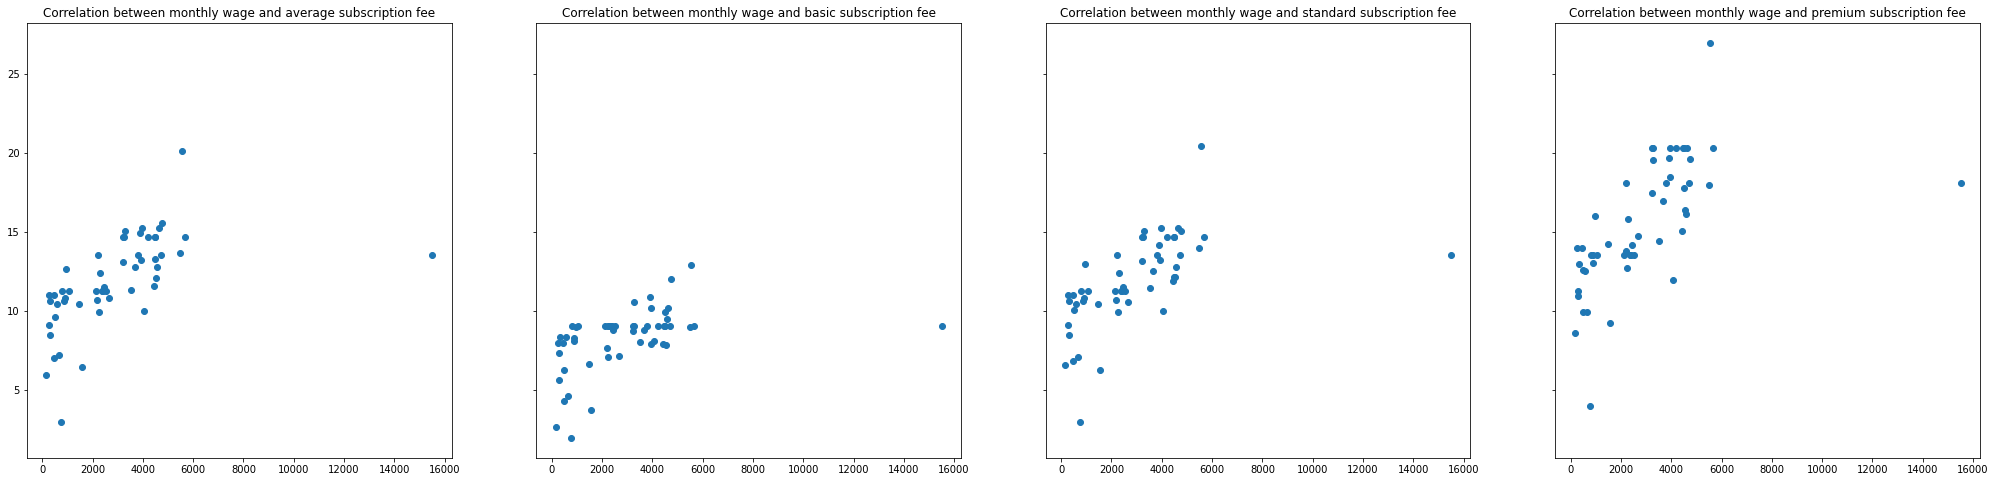

In [14]:
mnth_wage = data['mnth_wage']
avg_price = (data['basic_fee_mnth']+data['premium_fee_mnth']+data['std_fee_mnth'])/3
basic_fee = data['basic_fee_mnth']
premium_fee = data['premium_fee_mnth']
std_fee = data['std_fee_mnth']
fig, ax = plt.subplots(1, 4, figsize = (35, 8), sharex = True, sharey=True)
ax[0].scatter(mnth_wage, avg_price)
ax[0].set_title('Correlation between monthly wage and average subscription fee')
ax[1].scatter(mnth_wage, basic_fee)
ax[1].set_title('Correlation between monthly wage and basic subscription fee')
ax[2].scatter(mnth_wage, std_fee)
ax[2].set_title('Correlation between monthly wage and standard subscription fee')
ax[3].scatter(mnth_wage, premium_fee)
ax[3].set_title('Correlation between monthly wage and premium subscription fee')
plt.show()

### Зависимость цены подписки от валюты

In [15]:
#мэппинг страны и валюты

sheet_id = '1pYIiDFisiVwEvQA8fJEIkTjdXR1J4_-z73aLE7E-Jkg'
sheet_name = 'currency_mapping'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
cur = pd.read_csv(url)
cur.head()

,Country,Basic,Currency
0,Turkey,26.99,TRY
1,India,199.00,INR
2,Argentina,379.00,ARS
3,Colombia,16900.00,COP
4,Brazil,25.90,BRL


In [16]:
#развернутые названия валют

sheet_id = '1pYIiDFisiVwEvQA8fJEIkTjdXR1J4_-z73aLE7E-Jkg'
sheet_name = 'currencies_names'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
cur_names = pd.read_csv(url)
cur_names.head()

,Country,Currency,Code,Number
0,AFGHANISTAN,Afghani,AFN,971.0
1,ÅLAND ISLANDS,Euro,EUR,978.0
2,ALBANIA,Lek,ALL,8.0
3,ALGERIA,Algerian Dinar,DZD,12.0
4,AMERICAN SAMOA,US Dollar,USD,840.0


In [17]:
cur_names = cur_names[['Currency', 'Code']]
cur_names = cur_names.drop_duplicates()
cur_names = cur_names.rename(columns={'Code':'currency', 'Currency':'cur_name'})
cur_names.head()

,cur_name,currency
0,Afghani,AFN
1,Euro,EUR
2,Lek,ALL
3,Algerian Dinar,DZD
4,US Dollar,USD


In [18]:
cur = cur.rename(columns={'Country':'country', 'Currency':'currency'})
cur['country'] = cur['country'].replace({'Czech Republic':'Czechia'})
cur.head()

,country,Basic,currency
0,Turkey,26.99,TRY
1,India,199.00,INR
2,Argentina,379.00,ARS
3,Colombia,16900.00,COP
4,Brazil,25.90,BRL


In [19]:
cur = cur.merge(cur_names, how='left', on='currency')
cur.head()

,country,Basic,currency,cur_name
0,Turkey,26.99,TRY,Turkish Lira
1,India,199.00,INR,Indian Rupee
2,Argentina,379.00,ARS,Argentine Peso
3,Colombia,16900.00,COP,Colombian Peso
4,Brazil,25.90,BRL,Brazilian Real


In [20]:
data = data.merge(cur, how='left', on='country')
data.head()

,country_code,country,total_library_size,n_tv_shows,n_movies,basic_fee_mnth,std_fee_mnth,premium_fee_mnth,annual_wage,mnth_wage,Basic,currency,cur_name
0,au,Australia,6114,4050,2064,7.84,12.12,16.39,54401.0,4533.42,10.99,AUD,Australian Dollar
1,at,Austria,5640,3779,1861,9.03,14.67,20.32,53903.0,4491.92,7.99,EUR,Euro
2,be,Belgium,4990,3374,1616,10.16,15.24,20.32,55590.0,4632.50,8.99,EUR,Euro
3,ca,Canada,6239,4311,1928,7.91,11.87,15.03,53198.0,4433.17,9.99,CAD,Canadian Dollar
4,cl,Chile,4994,3156,1838,7.07,9.91,12.74,26916.0,2243.00,5940.00,CLP,Chilean Peso


**1) Какая средняя цена подписки, (базовой, стандартной, премиум) в зависимости от валюты страны.**

In [21]:
round(data.groupby('cur_name').mean()[['basic_fee_mnth','std_fee_mnth', 'premium_fee_mnth']].sort_values(by = 'basic_fee_mnth', ascending=False),2)

,basic_fee_mnth,std_fee_mnth,premium_fee_mnth
cur_name,,,
Swiss Franc,12.88,20.46,26.96
Danish Krone,12.00,15.04,19.60
Swedish Krona,10.90,14.20,19.70
New Israeli Sheqel,10.56,15.05,19.54
Norwegian Krone,9.94,12.17,17.75
New Taiwan Dollar,9.74,11.90,14.07
Singapore Dollar,9.51,12.81,16.11
Euro,8.98,13.05,17.12
Czech Koruna,8.83,11.49,14.15


### Зависимость цены подписки от континента

In [22]:
#мэппинг континентов

sheet_id = '1pYIiDFisiVwEvQA8fJEIkTjdXR1J4_-z73aLE7E-Jkg'
sheet_name = 'continents'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
continents = pd.read_csv(url)
continents.head()

,No,Country or Area,ISO-alpha3 Code,M49 Code,Region 1,Region 2,Continent
0,1,Afghanistan,AFG,4,Southern Asia,NaN,Asia
1,2,Åland Islands,ALA,248,Northern Europe,NaN,Europe
2,3,Albania,ALB,8,Southern Europe,NaN,Europe
3,4,Algeria,DZA,12,Northern Africa,NaN,Africa
4,5,American Samoa,ASM,16,Polynesia,NaN,Oceania


In [23]:
#корректируем названия стран, чтобы все хорошо приджойнилось
continents['Country or Area'] = continents['Country or Area'].replace({'Russian Federation': 'Russia', 
                                       'Republic of Korea': 'South Korea', 
                                       'United Kingdom of Great Britain and Northern Ireland':'United Kingdom',
                                       'Bolivia (Plurinational State of)':'Bolivia',
                                       'China, Hong Kong Special Administrative Region':'Hong Kong',
                                       'Republic of Moldova':'Moldova',
                                       'Venezuela (Bolivarian Republic of)':'Venezuela',
                                       'United States of America':'United States'
                                      })

In [24]:
test = data.merge(continents, how='left', left_on = 'country', right_on='Country or Area')
test.at[59, 'Continent'] = 'Asia'

data_full = test[['country_code', 'country', 'total_library_size', 'n_tv_shows', 'n_movies', 'basic_fee_mnth', 'std_fee_mnth', 'premium_fee_mnth', 'annual_wage', 'mnth_wage', 'currency', 'cur_name','Continent']]
data_full = data_full.rename(columns={'Continent':'continent'})

**2) Какая средняя цена подписки, (базовой, стандартной, премиум) в зависимости от континента**

In [25]:
round(data_full.groupby('continent').mean()[['basic_fee_mnth','std_fee_mnth', 'premium_fee_mnth']].sort_values(by = 'basic_fee_mnth', ascending=False), 2)

,basic_fee_mnth,std_fee_mnth,premium_fee_mnth
continent,,,
Europe,9.23,13.30,17.55
Oceania,8.32,12.32,16.66
North America,8.08,11.88,15.20
Asia,7.64,10.40,12.97
South America,6.71,9.62,12.56
Africa,6.26,10.05,12.58


### Стоимость подписки относительно среднего дохода в Чехии

In [26]:
def get_fee_percent_wage(name_country: str):
    subset = data_full[data_full['country'] == name_country]
    prices = round((subset[['basic_fee_mnth','std_fee_mnth', 'premium_fee_mnth']]/subset['mnth_wage'].values[0])*100,2).T
    prices.columns = ['Percentage of monthly wage']
    prices['Percentage of monthly wage'] = prices['Percentage of monthly wage'].apply(lambda x: str(x) + '%')
    return prices


**3) Сколько стоит подписка относительно среднего дохода (базовая, стандартная, премиум) в Чехии?**

In [27]:
get_fee_percent_wage('Czechia')

,Percentage of monthly wage
basic_fee_mnth,0.36%
std_fee_mnth,0.47%
premium_fee_mnth,0.58%


### Топ-5 стран с самой большой коллекцией сериалов

**4) Какие топ-5 стран имеют самую большую доступную коллекцию сериалов?**

In [28]:
data_full[['country', 'n_tv_shows']].sort_values(by='n_tv_shows', ascending=False).head(5).reset_index()[['country', 'n_tv_shows']]

,country,n_tv_shows
0,Czechia,5234
1,Slovakia,5055
2,Bulgaria,4819
3,Hungary,4802
4,United Kingdom,4551


### Стоимость подписки относительно среднего дохода в России

**5)Какой процент среднего дохода россиянина будет составлять подписка Netflix?**

In [29]:
get_fee_percent_wage('Russia')

,Percentage of monthly wage
basic_fee_mnth,0.91%
std_fee_mnth,1.22%
premium_fee_mnth,1.52%


### Cost per title - место России

In [30]:
#добавим новые метрики

data_full['cost_per_title_basic'] = data_full['basic_fee_mnth']/data_full['total_library_size']
data_full['cost_per_title_std'] = data_full['std_fee_mnth']/data_full['total_library_size']
data_full['cost_per_title_prem'] = data_full['premium_fee_mnth']/data_full['total_library_size']

In [31]:
def get_country_place(metric: str, name_country: str):
    text = name_country + "'s place for " + metric + ' is ' 
    subset = data_full.sort_values(by=metric).reset_index()
    return print(text+ str(subset.index[subset['country']==name_country].tolist()[0]))

**6) На каком месте будет Россия, если отсортировать страны по эффективности подписки (Cost Per Title)**

In [32]:
get_country_place('cost_per_title_basic', 'Russia')
get_country_place('cost_per_title_std', 'Russia')
get_country_place('cost_per_title_prem', 'Russia')

Russia's place for cost_per_title_basic is 25
Russia's place for cost_per_title_std is 17
Russia's place for cost_per_title_prem is 17


### В какой стране лучше всего брать ВПН, чтобы платить за Netflix меньше всего

Если нам не сильно важен объем библиотеки, то нужно выбрать страну, где стоимость подписки ниже всего 

Если мы хотим не только самую дешевую подписку, но и оптимальную с точки зрения стоимости 1го фильма/сериала, то выбирать нужно по цене за позицию (в зависимости от тарифного плана)

In [33]:
def select_best_country_for_vpn(metric: str):
    text = 'Best country to take VPN considering "'+metric+'" metric is '
    subset = data_full[['country', metric]]
    return print(text + subset.sort_values(by=metric).reset_index().iloc[0]['country'])

In [34]:
data_full['cost_to_library_basic'] = data_full['total_library_size'] / data_full['basic_fee_mnth']
data_full['cost_to_library_std'] = data_full['total_library_size'] / data_full['std_fee_mnth']
data_full['cost_to_library_premium'] = data_full['total_library_size'] / data_full['premium_fee_mnth']

In [35]:
select_best_country_for_vpn('cost_per_title_basic')
select_best_country_for_vpn('cost_per_title_std')
select_best_country_for_vpn('cost_per_title_prem')
print('-------------------------------------------------------------------------------')
select_best_country_for_vpn('basic_fee_mnth')
select_best_country_for_vpn('std_fee_mnth')
select_best_country_for_vpn('premium_fee_mnth')

Best country to take VPN considering "cost_per_title_basic" metric is Turkey
Best country to take VPN considering "cost_per_title_std" metric is Turkey
Best country to take VPN considering "cost_per_title_prem" metric is Turkey
-------------------------------------------------------------------------------
Best country to take VPN considering "basic_fee_mnth" metric is Turkey
Best country to take VPN considering "std_fee_mnth" metric is Turkey
Best country to take VPN considering "premium_fee_mnth" metric is Turkey


**7) В какой стране лучше всего брать VPN для того, чтобы платить за Netflix меньше всего?**

По всем параметрам выигрывает **Турция!**:) Нужно подключаться к турецкому VPN